# Algorithms for Data Science

## Finding Similar Items

The objective of this lab is to implement the Min-Hashing and Locality Sensitive Hashing. This lab needs Python and Jupyter, along with the NumPy package.

1. We first load the required libraries and the files containing the documents.

In [13]:
import sys
import numpy as np
import urllib.request
import re
import string
import random

file_location = 'https://www.lri.fr/~maniu/tweets.txt' #you can change this to a local file on your computer

#keeping document in memory
infile = urllib.request.urlopen(file_location)
docs = []
for line in infile: 
  docs.append(str(line.strip()).lower())
print("Number of documents: %d"%len(docs))
print(docs[:3])

Number of documents: 497
["b'@stellargirl i loooooooovvvvvveee my kindle2. not that the dx is cool, but the 2 is fantastic in its own right.'", "b'reading my kindle2...  love it... lee childs is good read.'", "b'ok, first assesment of the #kindle2 ...it fucking rocks!!!'"]


2. We transform the document into $k$-shingles, and we hash them to their integer values. We compute the Jaccard similarity between two documents given as sets of shingle ids.

In [14]:
k = 5 #k for shingles

shingle_id = {}
id_shingle = []
m = []
ids = 0

total_shingles = 0

for d in docs:
  #removing whitespace
  d_new = ''.join(c for c in d if c.isalnum())
  char_shing = [d_new[i:i+k] for i in range(len(d_new)-k+1)]
  total_shingles += len(char_shing)
  sid = set()
  for sh in char_shing:
    if sh not in shingle_id:
      shingle_id[sh]=ids
      id_shingle.append(sh)
      ids=ids+1
    sid.add(shingle_id[sh])
  m.append(sid)

print ("Unique shingles: %d"%len(id_shingle))
print ("Total shingles: %d"%total_shingles)
  

Unique shingles: 19532
Total shingles: 28150


In [18]:
m[0]

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80}

In [9]:
def jaccard_similarity(doc1, doc2):
  if len(doc1)==0 or len(doc2)==0:
    return 0.0
  else:
    inter = doc1.intersection(doc2)
    union = doc1.union(doc2)
    return float(len(inter))/float(len(union))

#example

print(jaccard_similarity(m[0],m[1]))

0.043859649122807015


3. We implement the method for min-hashing given a permutation.

In [31]:
def min_hash(doc, perm):
  for d in perm:
    if d in doc: return d

perm = list(range(len(id_shingle)))
random.shuffle(perm)

min_hash(m[0],perm)

print(len(m))
print(len(id_shingle))


497
19532


4. Implement the full Min-Hashing signature matrix for a given number $n$ of permutations. Implement the similarity estimation based on Min-Hashing (i.e., the number of permutation on which two documents agree).

In [11]:
def min_hashing_signature_matrix(docs:list, perms:list) -> list:
    '''
    description: Implement the full Min-Hashing signature matrix for a given number n of permutations.

    param {list} docs: input documents
    param {list} perms: input random permutations list
    return {list} signature: min-hashing signture matrix
    '''
    signature = []
    for doc in docs:
        h_matrix = []
        for perm in perms:
            h_matrix.append(min_hash(doc, perm))
        signature.append(h_matrix)
    return signature


def similarity_estimation(signature1:list, signature2:list) -> float:
    '''
    description: Implement the similarity estimation based on Min-Hashing.
    param {list} signature1 input documents 1's signature matrix
    param {list} signature2 input documents 2's signature matrix
    return {float} similarity: the estimated similarity between two signatures matrices.
    '''
    count_agreement = 0
    for i,value in enumerate(signature1):
        if value == signature2[i]:
            count_agreement += 1
    similarity = count_agreement/len(signature1)
    return similarity
    

def gen_permuatations(n_perms: int) -> list:
    '''
    description: generate permutations
    param {int} n_perms: number of permutations
    return {list} perms: pertumation matrix
    '''
    perms = []
    for i in range(n_perms):
        perm = list(range(len(id_shingle)))
        random.shuffle(perm)
        perms.append(perm)
    return perms

# estimate the similarity
n_perms = 100
signatures = min_hashing_signature_matrix(m, gen_permuatations(n_perms))
print(similarity_estimation(signatures[0], signatures[1]))


0.06


In [20]:
len(signatures[0])

100

5. __TASK__ Implement Locality-Sensitive Hashing, given $b$ bands of $r$ rows such that $br=n$. Compute the similarity threshold needed using the formula in the lecture $t=(1/b)^{1/r}$. Assume that signatures in the same band are similar only if the are the same (i.e., they agree on all columns). Check for similarity all documents that agree in at least one band, and compare with the true jaccard similarity.

In [12]:
import itertools

# define similarity threshold, find b and r
b = 20
r = int(len(signatures[0])/b)
t = pow((1/b),(1/r))


def get_all_bands(b: int, r: int, signatures: list) -> list:
    '''
    description: Get the the result of all the band dictionaries. For each dictionary, 
                 keys are the hashes of the partial signatures, values are lists of document ids.
    param {int} b: number of bands
    param {int} r: number of rows
    param {list} signatures: signatures matrix of all the documents.
    return {list} all_bands: a list including all the band dictionaries.
    '''
    doc_ids = []
    all_bands = []
    # each document is an array of length n, devide it into b bands of r values
    sig_length = len(signatures[0])
    for i in range(0, sig_length, r):
        sub_signature = []
        # have a dictionary (per band), keys are the hashes of the partial signatures, values are lists of document ids
        band_dict = {}
        for doc_id, sub_signature in enumerate(np.array(signatures).T[i: i+r].T):
            key = str(sub_signature)
            #  add the document id to the list as the dict values, and keys are the corresponding hash of the partial signatures.
            if key in list(band_dict.keys()):
                band_dict[key].append(doc_id)
            else:
                band_dict[key] = [doc_id]
        all_bands.append(band_dict)
    return all_bands
    

def get_similar_documents_using_jaccard(t: int, all_bands: list) -> list:
    '''
    description: check for similarity all documents that agree in at least one band, 
                 and compare with the true jaccard similarity.
    param {int} t: similarity threshold needed using the formula t=(1/b)^{1/r}.
    param {list} all_bands: the result of all the band dictionaries. 
    return {list} similar_documents: the results of the similar documents pairs.
           {list} jaccard_similarity_list: the corresponding jaccard similarity of the similar documents pairs.
    '''
    similar_documents = []
    jaccard_similarity_list = []
    # loop over the values in the band_dict, retrieve list in each key
    for band_dict in all_bands:
        for key, values in band_dict.items():
            # calculate the similarity for each pair
            combinations = list(itertools.combinations(values, 2))
            for combination in combinations:
                sim = jaccard_similarity(m[combination[0]], m[combination[1]])
                # reject the pair if similarity is smaller than the threshold
                if sim > t and [combination[0], combination[1]] not in similar_documents:
                    similar_documents.append([combination[0], combination[1]])
                    jaccard_similarity_list.append(sim)
    return similar_documents, jaccard_similarity_list

# check the results of the similar pairs of documents with corresponding similarities.
all_bands = get_all_bands(b, r, signatures)
similar_documents, jaccard_similarity_list = get_similar_documents_using_jaccard(t, all_bands)
if similar_documents == []:
    print("There are not similar pairs of documents.")
else:
    for i, val in enumerate(similar_documents):
        print("The similariry pairs of documents is {}, with the similarity {}"
                .format(str(val), str(jaccard_similarity_list[i])))

The similariry pairs of documents is [110, 352], with the similarity 0.6615384615384615
The similariry pairs of documents is [61, 63], with the similarity 0.5555555555555556
The similariry pairs of documents is [244, 245], with the similarity 0.65
The similariry pairs of documents is [124, 363], with the similarity 0.6363636363636364


Adjust the parameters, to see the change of different curves and the correlation between probability and similarity.

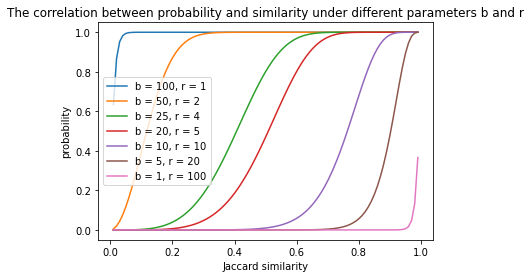

In [135]:
import matplotlib.pyplot as plt


def calculate_probability(s, r, b):
    '''
    description: calculate the probability with different parameters
    param {float} s
    param {int} r
    param {int} b
    return {float} probability
    '''
    probability = 1 - (1 - s**r)**b
    return probability

# play with the parameters
b_list = [100, 50, 25, 20, 10, 5, 1]
sig_length = len(signatures[0])
r_list = [round(sig_length/100), round(sig_length/50),round(sig_length/25), round(sig_length/20), 
          round(sig_length/10), round(sig_length/5),round(sig_length/1)]

# plot the probability figure.
p_results_all = []
for i, b in enumerate(b_list):
    r = r_list[i]
    p_result = []
    for s in np.arange(0.01, 1, 0.01):
        p = calculate_probability(s, r, b)
        p_result.append(p)
    p_results_all.append(p_result)

for i, p_result in enumerate(p_results_all):
    plt.plot(np.arange(0.01, 1, 0.01), p_result, label="b = {}, r = {}".format(str(b_list[i]), str(r_list[i])))
plt.ylabel('probability')
plt.xlabel('Jaccard similarity')
plt.title("The correlation between probability and similarity under different parameters b and r")
plt.legend()